<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/dimred/vae_mnist_gdl_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Variational) Autoencoder using convolutional encoder/decoder


Code uses TF 2.0 idioms and should work with images of any size and number of channels. Code is based on various sources, including
- https://www.tensorflow.org/beta/tutorials/generative/cvae.
- https://github.com/davidADSP/GDL_code/blob/master/03_03_vae_digits_train.ipynb





## Import TensorFlow and other libraries

In [2]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. DNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

In [3]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display
import sklearn
#from time import time

np.random.seed(0)

## Load the dataset


In [34]:
dataname = 'mnist' 
#dataname = 'fashion_mnist'
#dataname = 'cifar10' # https://www.tensorflow.org/datasets/catalog/cifar10

# Useful pre-processing functions
#https://github.com/google/compare_gan/blob/master/compare_gan/datasets.py
  
datasets, datasets_info = tfds.load(name=dataname, with_info=True, as_supervised=False)
print(datasets_info)

input_shape = datasets_info.features['image'].shape
print(input_shape)
num_colors = input_shape[2]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteCNA9M2/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteCNA9M2/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashio

In [35]:
batchsize = 64
# We assume the dataset has a dict of features called image and label.
# We extract the image from the dict, and scale each channel to [0,1]
# We return a tuple (rescaled-image, label).
def scale_pixels(sample):
  img = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
  label = sample['label']
  return img, label

def scale_pixels_and_drop_label(sample):
  img = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
  return img
  
drop_label = True
if drop_label:
  preprocess = scale_pixels_and_drop_label
else:
  preprocess = scale_pixels
  
def preprocess_celeba(features):
    """Returns 64x64x3 image and constant label."""
    image = features["image"]
    image = tf.image.resize_image_with_crop_or_pad(image, 160, 160)
    # Note: possibly consider using NumPy's imresize(image, (64, 64))
    image = tf.image.resize_images(image, [64, 64])
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.constant(0, dtype=tf.int32)
    return image, label
    

train_dataset = (datasets['train']
                 .map(preprocess)
                 .batch(batchsize)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 .shuffle(int(10e3)))
test_dataset = (datasets['test']
                .map(preprocess)
                .batch(batchsize)
                .prefetch(tf.data.experimental.AUTOTUNE))



In [36]:
# To make it easy to perform random access to the test set,
# we convert to a vanilla numpy array
test_ds = tfds.as_numpy(datasets['test'].map(scale_pixels_and_drop_label))
L = list(test_ds) # force the generator to yield
x_test = np.stack(L, axis=0) # 10k, 28, 28, 1
print(x_test.shape)

def extract_label(sample):
  return sample['label']

test_ds = tfds.as_numpy(datasets['test'].map(extract_label))
L = list(test_ds) # force the generator to yield
y_test = np.stack(L, axis=0) # 10k

n_test = len(y_test)
print(n_test)

(10000, 28, 28, 1)
10000


In [37]:
# Inspect the dataset we just created
i = 0
for batch in train_dataset:
  if drop_label:
    X = batch
    print(X.shape)
  else:
    X, y = batch
    print(X.shape)
    print(y.shape)
  i += 1
  if i > 1:
    break

(64, 28, 28, 1)
(64, 28, 28, 1)


In [38]:
# extract small amount of data for testing
batch = train_dataset.take(1) # slow!!!
first_batch = list(batch)
if drop_label:
  X = first_batch[0]
else:
  X, y = first_batch[0]
print(X.shape) # B, H, W, C
Xsmall = X[:3, :, :, :]
print(Xsmall.shape)

(64, 28, 28, 1)
(3, 28, 28, 1)


# Define model

In [9]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [39]:
def make_encoder(
        input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout= False
        , deterministic = False
        ):
  encoder_input = Input(shape=input_dim, name='encoder_input')
  x = encoder_input
  n_layers_encoder = len(encoder_conv_filters)
  for i in range(n_layers_encoder):
      conv_layer = Conv2D(
          filters = encoder_conv_filters[i]
          , kernel_size = encoder_conv_kernel_size[i]
          , strides = encoder_conv_strides[i]
          , padding = 'same'
          , name = 'encoder_conv_' + str(i)
          )
      x = conv_layer(x)
      if use_batch_norm:
          x = BatchNormalization()(x)
      x = LeakyReLU()(x)
      if use_dropout:
          x = Dropout(rate = 0.25)(x)
  shape_before_flattening = K.int_shape(x)[1:]
  x = Flatten()(x)
  mu = Dense(z_dim, name='mu')(x) # no activation
  if deterministic:
    encoder = Model(encoder_input, mu)
  else: 
    log_var = Dense(z_dim, name='log_var')(x) # no activation
    encoder = Model(encoder_input, (mu, log_var))
  return encoder, shape_before_flattening



In [40]:
# Test
encoder, shape_before_flattening = make_encoder(
    input_dim = input_shape
    , encoder_conv_filters = [32,64]
    , encoder_conv_kernel_size = [3,3]
    , encoder_conv_strides = [2,2]
    , z_dim = 2
)
print(encoder.summary())



Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_22 (LeakyReLU)      (None, 14, 14, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 7, 7, 64)     18496       leaky_re_lu_22[0][0]             
______________________________________________________________________________________

In [41]:
# Test
encoder2, shape_before_flattening = make_encoder(
    input_dim = input_shape
    , encoder_conv_filters = [32,64]
    , encoder_conv_kernel_size = [3,3]
    , encoder_conv_strides = [2,2]
    , z_dim = 2
    , deterministic = True
)
print(encoder2.summary())

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 3136)              0         
_________________________________________________________________
mu (Dense)                   (None, 2)               

In [42]:
print(shape_before_flattening)
print(Xsmall.shape)
M, V = encoder(Xsmall)
print(M.shape)
print(V.shape)

(7, 7, 64)
(3, 28, 28, 1)
(3, 2)
(3, 2)


In [43]:
def make_decoder(
        shape_before_flattening
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout= False
        ):
  decoder_input = Input(shape=(z_dim,), name='decoder_input')
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)
  n_layers_decoder = len(decoder_conv_t_filters)
  for i in range(n_layers_decoder):
      conv_t_layer = Conv2DTranspose(
          filters = decoder_conv_t_filters[i]
          , kernel_size = decoder_conv_t_kernel_size[i]
          , strides = decoder_conv_t_strides[i]
          , padding = 'same'
          , name = 'decoder_conv_t_' + str(i)
          )
      x = conv_t_layer(x)
      if i < n_layers_decoder - 1:
          if use_batch_norm:
              x = BatchNormalization()(x)
          x = LeakyReLU()(x)
          if use_dropout:
              x = Dropout(rate = 0.25)(x)
      # No activation fn in final layer since returns logits
      #else:
      #    x = Activation('sigmoid')(x)
  decoder_output = x
  decoder = Model(decoder_input, decoder_output)
  return decoder
  


In [44]:
# Test
decoder = make_decoder(
    shape_before_flattening
    , decoder_conv_t_filters = [64,32,num_colors]
    , decoder_conv_t_kernel_size = [3,3,3]
    , decoder_conv_t_strides = [2,2,1]
    , z_dim = 2
)
print(decoder.summary())



Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 28, 28, 32)        18464     
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 28, 28, 32)      

In [45]:
Z = np.random.randn(5, 2).astype(np.float32)
Xrecon = decoder(Z)
print(Xrecon.shape)

(5, 28, 28, 1)


In [18]:

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def sample_gauss(mean, logvar):
  eps = tf.random.normal(shape=mean.shape)
  return eps * tf.exp(logvar * .5) + mean

In [25]:
class ConvVAE(tf.keras.Model):
  def __init__(self,
        input_dim,
        encoder_conv_filters,
        encoder_conv_kernel_size,
        encoder_conv_strides,
        decoder_conv_t_filters,
        decoder_conv_t_kernel_size,
        decoder_conv_t_strides,
        z_dim,
        use_batch_norm = False,
        use_dropout= False,
        recon_loss_scaling = 1,
        kl_loss_scaling = 1,
        use_mse_loss = False,
        deterministic = False,
        model_name = ''
        ):
    super(ConvVAE, self).__init__()
    self.latent_dim = z_dim
    self.recon_loss_scaling = recon_loss_scaling
    self.kl_loss_scaling = kl_loss_scaling
    self.use_mse_loss = use_mse_loss
    self.deterministic = deterministic
    self.model_name = model_name
    self.inference_net, self.shape_before_flattening = make_encoder(
        input_dim,
        encoder_conv_filters,
        encoder_conv_kernel_size,
        encoder_conv_strides,
        z_dim,
        use_batch_norm,
        use_dropout,
        deterministic)
    self.generative_net = make_decoder(
        self.shape_before_flattening,
        decoder_conv_t_filters,
        decoder_conv_t_kernel_size,
        decoder_conv_t_strides,
        z_dim,
        use_batch_norm,
        use_dropout)

  @tf.function
  def sample(self, nsamples=1):
    eps = tf.random.normal(shape=(nsamples, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode_stochastic(self, x):
    mean, logvar = self.inference_net(x)
    return sample_gauss(mean, logvar)

  def encode_deterministic(self, x):
    mean = self.inference_net(x)
    return mean

  def encode(self, x):
    if self.deterministic:
      return self.encode_deterministic(x)
    else:
      #return self.encode_stochastic(x)
      mean, logvar = self.inference_net(x)
      return mean

  def decode(self, z, apply_sigmoid=True):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits
  
  
  @tf.function
  def compute_loss(self, x):
    if self.deterministic:
      mean = self.inference_net(x)
      z = mean
    else: 
      mean, logvar = self.inference_net(x)
      z = sample_gauss(mean, logvar)
    if self.use_mse_loss:
      x_probs = self.decode(z, apply_sigmoid=True)
      mse = tf.reduce_mean( (x - x_probs) ** 2, axis=[1, 2, 3])
      logpx_z = -0.5*mse # log exp(-0.5 (x-mu)^2)
    else:
      x_logit = self.decode(z, apply_sigmoid=False)
      cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x) # -sum_{c=0}^1 p_c log q_c
      logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3]) # sum over H,W,C
    if self.deterministic:
      return -tf.reduce_mean(logpx_z) # -ve log likelihood
    else:
      logpz = log_normal_pdf(z, 0., 0.) # prior: mean=0, logvar=0
      logqz_x = log_normal_pdf(z, mean, logvar)
      kl_loss = logpz - logqz_x # MC approximation
      return -tf.reduce_mean(self.recon_loss_scaling * logpx_z + self.kl_loss_scaling * kl_loss) # -ve ELBO

          
  @tf.function
  def compute_gradients(self, x):
    with tf.GradientTape() as tape:
      loss = self.compute_loss(x)
    gradients = tape.gradient(loss, self.trainable_variables)
    return gradients


In [46]:

# Match setting from
# https://github.com/davidADSP/GDL_code/blob/master/03_03_vae_digits_train.ipynb


if 1:
  encoder_conv_filters = [32,64]
  encoder_conv_kernel_size = [3,3]
  encoder_conv_strides = [2,2]
  decoder_conv_t_filters = [64,32,num_colors]
  decoder_conv_t_kernel_size = [3,3,3]
  decoder_conv_t_strides = [2,2,1]
else:
  encoder_conv_filters = [32,64,64, 64]
  encoder_conv_kernel_size = [3,3,3,3]
  encoder_conv_strides = [1,2,2,1]
  decoder_conv_t_filters = [64,64,32,num_colors]
  decoder_conv_t_kernel_size = [3,3,3,3]
  decoder_conv_t_strides = [1,2,2,1]

names = ['2d_det', '20d_det', '2d_stoch', '20d_stoch']
deterministic = [True, True, False, False]
latent_dims = [2, 20, 2, 20]
models = []
for i in range(4):
  model = ConvVAE(
      input_dim = input_shape,
      encoder_conv_filters = encoder_conv_filters,
      encoder_conv_kernel_size = encoder_conv_kernel_size,
      encoder_conv_strides = encoder_conv_strides,
      decoder_conv_t_filters = decoder_conv_t_filters,
      decoder_conv_t_kernel_size = decoder_conv_t_kernel_size,
      decoder_conv_t_strides = decoder_conv_t_strides,
      z_dim = latent_dims[i],
      recon_loss_scaling = 1000,
      use_mse_loss = True, 
      deterministic = deterministic[i],
      model_name = names[i])
  print(model)
  models.append(model)


model_dict = {}
for model in models:
  model_dict[model.model_name] = model

In [47]:
# Test
print('size of batch {}'.format(Xsmall.shape))
for model in models:
  print(model.model_name)
  if model.deterministic:
    M = model.inference_net(Xsmall)
    print('size of encoding head: mean {}'.format(M.shape))
  else:
    M, V = model.inference_net(Xsmall)
    print('size of encoding head: mean {}, var {}'.format(M.shape, V.shape))
  Z = model.encode(Xsmall)
  print('size of encoding {}'.format(Z.shape))
  predictions = model.decode(Z)
  print('size of decoding {}'.format(predictions.shape))


size of batch (3, 28, 28, 1)
2d_det
size of encoding head: mean (3, 2)
size of encoding (3, 2)
size of decoding (3, 28, 28, 1)
20d_det
size of encoding head: mean (3, 20)
size of encoding (3, 20)
size of decoding (3, 28, 28, 1)
2d_stoch
size of encoding head: mean (3, 2), var (3, 2)
size of encoding (3, 2)
size of decoding (3, 28, 28, 1)
20d_stoch
size of encoding head: mean (3, 20), var (3, 20)
size of encoding (3, 20)
size of decoding (3, 28, 28, 1)


In [28]:
for model in models:
  print(model.model_name)
  L = model.compute_loss(Xsmall)
  print(L)
  g = model.compute_gradients(Xsmall)
  print(g[0].shape) # 3,3,1,32 - size of first layer conv

2d_det
tf.Tensor(0.11379913, shape=(), dtype=float32)
(3, 3, 1, 32)
20d_det
tf.Tensor(0.113810055, shape=(), dtype=float32)
(3, 3, 1, 32)
2d_stoch
tf.Tensor(114.144844, shape=(), dtype=float32)
(3, 3, 1, 32)
20d_stoch
tf.Tensor(113.99734, shape=(), dtype=float32)
(3, 3, 1, 32)


# Training


Epoch 0, Test loss: 0.11572, time 42.00


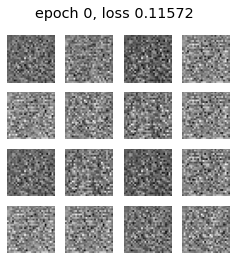

Epoch 0, Test loss: 0.11573, time 42.00


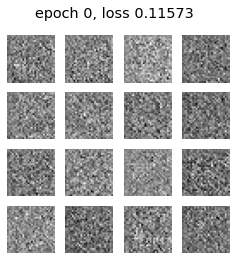

Epoch 0, Test loss: 116.01754, time 42.00


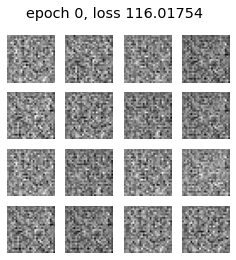

Epoch 0, Test loss: 115.99959, time 42.00


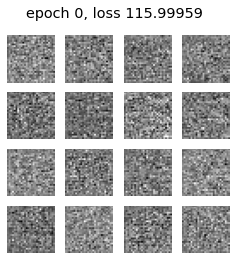

In [29]:
# Callback
def generate_images(model, epoch, noise_vector):
  predictions = model.decode(noise_vector)
  n = int(np.sqrt(num_examples_to_generate))
  fig = plt.figure(figsize=(n,n))
  for i in range(predictions.shape[0]):
      plt.subplot(n, n, i+1)
      if num_colors == 1:
         plt.imshow(predictions[i, :, :, 0], cmap='gray')
      else:
         plt.imshow(predictions[i, :, :, :])
      plt.axis('off')
  
  
num_examples_to_generate = 16
# We use fixed noise vector to generate samples during training so
# it will be easier to see the improvement.
random_noise = {}
for dim in np.unique(latent_dims):
  noise = tf.random.normal(shape=[num_examples_to_generate, dim])
  random_noise[dim] = noise

# we assume model.compute_loss(batch) is defined
# as well as test_dataset
def callback(model, epoch, elapsed_time):
  loss_tracker = tf.keras.metrics.Mean()
  for batch in test_dataset:
    loss_tracker(model.compute_loss(batch))
  test_loss = loss_tracker.result()
  #display.clear_output(wait=False) # don't erase old outputs
  print('Epoch {}, Test loss: {:0.5f}, time {:0.2f}'.format(
            epoch, test_loss, elapsed_time)) 
  noise = random_noise[model.latent_dim]
  generate_images(model, epoch, noise)
  plt.suptitle('epoch {}, loss {:0.5f}'.format(epoch, test_loss), fontsize='x-large')
  plt.savefig('model_{}_image_at_epoch_{:04d}.png'.format(model.model_name, epoch))
  plt.show()

  
  
# Test 
for model in models:
  callback(model, 0, 42)

In [30]:
# generic (model agnostic) training function.
# model must support these methods:
# g = model.compute_gradients(X)
# model.traininable_variables (so model is a subclass of Keras.Model)

# Callback has following interface: callback(model, epoch, elapsed_time)

def train_model(model, optimizer, train_dataset,
                epochs, callback=None, print_every_n_epochs=1):
  for epoch in range(0, epochs):
    start_time = time.time()
    for batch in train_dataset:
      gradients = model.compute_gradients(batch)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    end_time = time.time()
    elapsed_time = end_time - start_time
    if callback:
       callback(model, epoch, elapsed_time)                               
  return model

2d_det
Epoch 0, Test loss: 0.01745, time 7.29


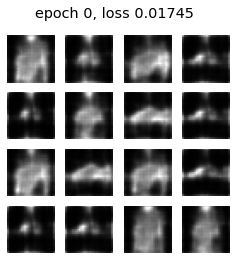

Epoch 1, Test loss: 0.01643, time 6.85


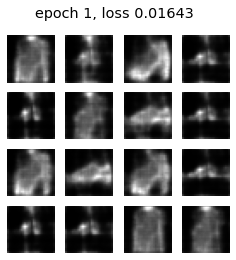

In [49]:

#optimizer = tf.keras.optimizers.SGD(1e-1)
optimizer = tf.keras.optimizers.Adam(1e-3)
epochs = 2
model = model_dict['2d_det']
print(model.model_name)
model = train_model(model, optimizer, train_dataset, epochs, callback)
 

2d_det
Epoch 0, Test loss: 0.02336, time 6.76


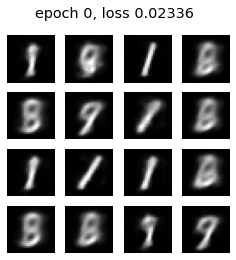

Epoch 1, Test loss: 0.02327, time 6.70


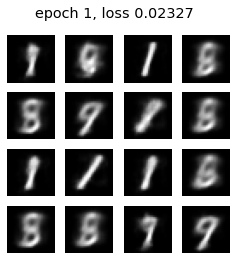

20d_det
Epoch 0, Test loss: 0.00370, time 6.76


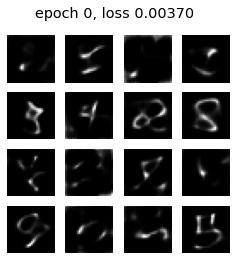

Epoch 1, Test loss: 0.00347, time 6.68


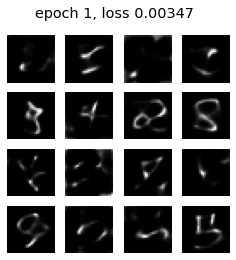

2d_stoch
Epoch 0, Test loss: 28.37840, time 7.84


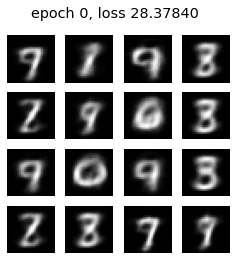

Epoch 1, Test loss: 27.79435, time 7.08


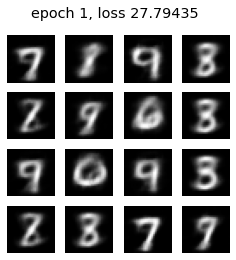

20d_stoch
Epoch 0, Test loss: 24.08021, time 7.88


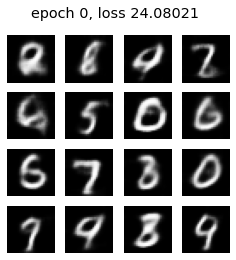

Epoch 1, Test loss: 23.32022, time 7.21


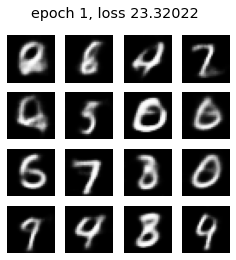

In [33]:

optimizer = tf.keras.optimizers.Adam(1e-3)
#optimizer = tf.keras.optimizers.Adam(1e-2)
epochs = 2
for i, model in enumerate(models):
  print(model.model_name)
  model = train_model(model, optimizer, train_dataset, epochs, callback)
  models[i] = model

# Post-training

### Display images generated (and saved) during training

In [109]:


def display_images_generated_during_training(model, epochs):
  for i in range(epochs):
    img = PIL.Image.open('model_{}_image_at_epoch_{:04d}.png'.format(model.model_name, i))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

2d_det


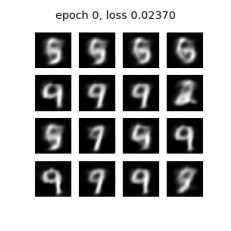

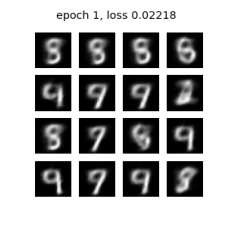

20d_det


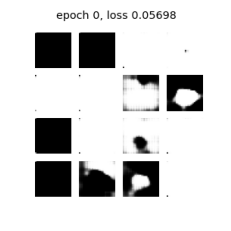

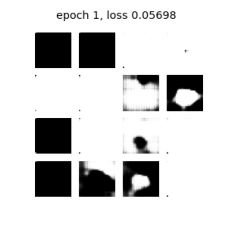

2d_stoch


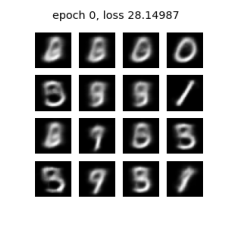

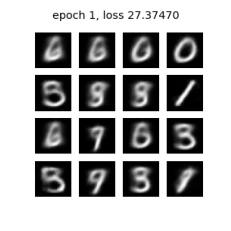

20d_stoch


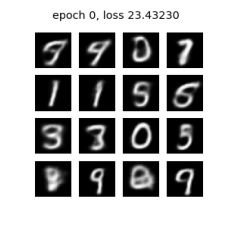

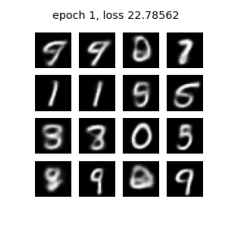

In [110]:
for model in models:
  print(model.model_name)
  display_images_generated_during_training(model, epochs)

## Reconstructions

2d_det
20d_det
2d_stoch
20d_stoch


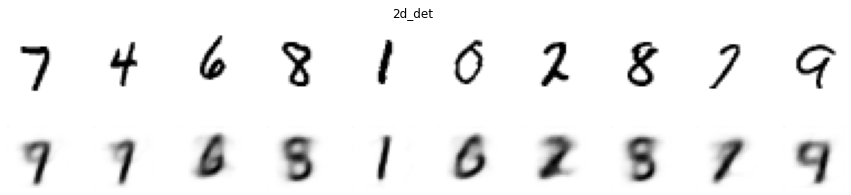

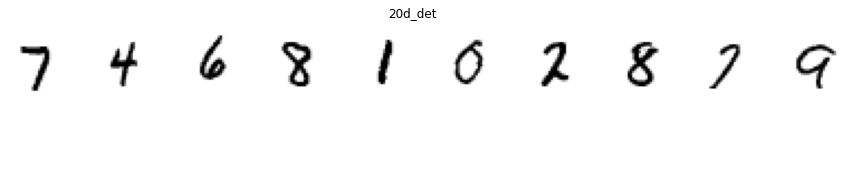

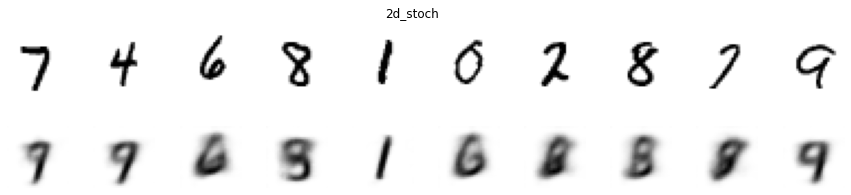

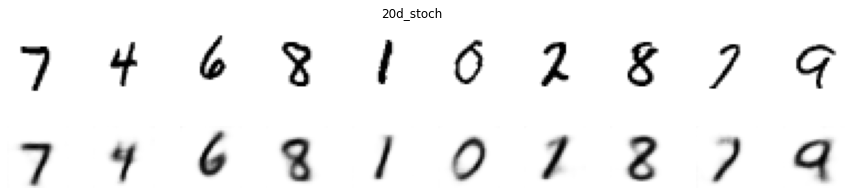

In [113]:
# Reconstruct images
def plot_reconstructions(model, n_to_show=10):
  np.random.seed(42)
  example_idx = np.random.choice(n_test, n_to_show)
  example_images = x_test[example_idx]

  z_points = model.encode(example_images)
  reconst_images = model.decode(z_points)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      #img = example_images[i].squeeze()
      img = example_images[i,:,:,0]
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')
      #sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)         
      sub.imshow(img, cmap='gray_r')

      #img = reconst_images[i].squeeze()
      img = reconst_images[i,:,:,0]
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img, cmap='gray_r')

      plt.suptitle(model.model_name)

for model in models:
  print(model.model_name)
  plot_reconstructions(model)

## 2d Embeddings

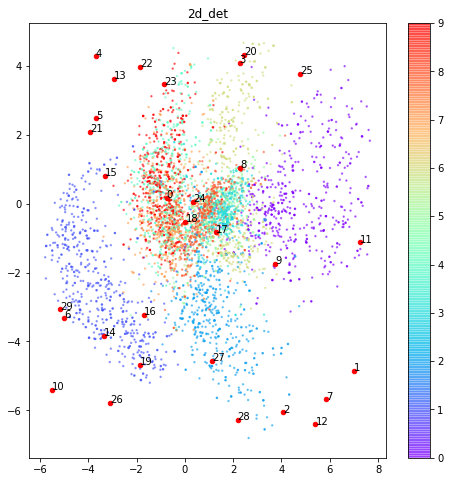

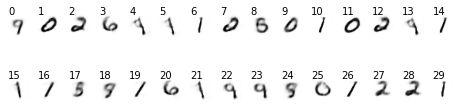

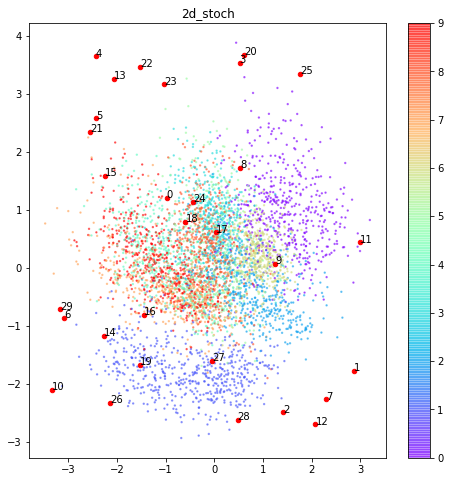

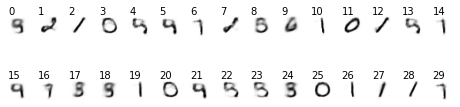

In [123]:
# generate images from random points in latent space

def sample_from_embeddings(model, n_to_show=5000):
  figsize = 8
  np.random.seed(42)
  example_idx = np.random.choice(range(n_test), n_to_show)
  example_images = x_test[example_idx]
  example_labels = y_test[example_idx]
  z_points = model.encode(example_images)

  plt.figure(figsize=(figsize, figsize))
  #plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
  plt.scatter(z_points[:, 0] , z_points[:, 1], cmap='rainbow', c=example_labels, alpha=0.5, s=2)
  plt.colorbar()

  grid_size = 15
  grid_depth = 2
  np.random.seed(42)
  x_min = np.min(z_points[:,0]); x_max = np.max(z_points[:,0]);
  y_min = np.min(z_points[:,1]); y_max = np.max(z_points[:,1]);
  x = np.random.uniform(low=x_min, high=x_max, size=grid_size*grid_depth)
  y = np.random.uniform(low=y_min, high=y_max, size=grid_size*grid_depth)
  #x = np.random.normal(size = grid_size * grid_depth)
  #y = np.random.normal(size = grid_size * grid_depth)
  z_grid = np.array(list(zip(x, y)))
  reconst = model.decode(z_grid)

  plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
  n = np.shape(z_grid)[0]
  for i in range(n):
    x = z_grid[i,0]
    y = z_grid[i,1]
    plt.text(x, y, i)
  plt.title(model.model_name)
  plt.show()

  fig = plt.figure(figsize=(figsize, grid_depth))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(grid_size*grid_depth):
      ax = fig.add_subplot(grid_depth, grid_size, i+1)
      ax.axis('off')
      #ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
      ax.text(0.5, -0.35, str(i))
      ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

sample_from_embeddings(model_dict['2d_det']) 
sample_from_embeddings(model_dict['2d_stoch']) 

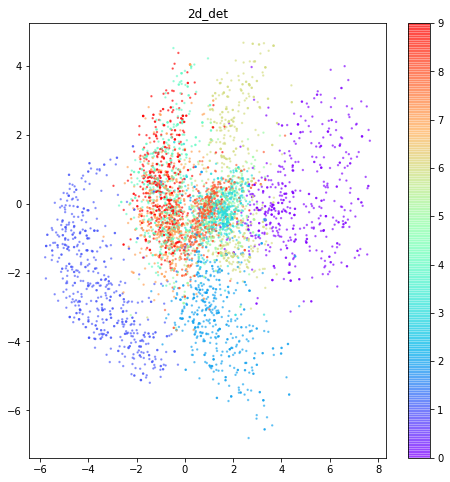

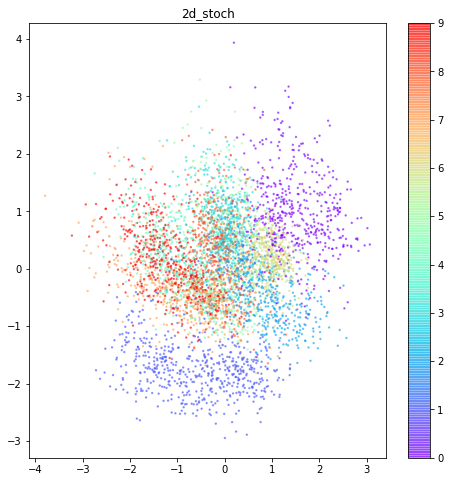

In [117]:
# color code latent points
from scipy.stats import norm

def show_2d_embeddings(model, n_to_show=5000, use_cdf=False):
  figsize = 8

  np.random.seed(42)
  example_idx = np.random.choice(range(len(x_test)), n_to_show)
  example_images = x_test[example_idx]
  example_labels = y_test[example_idx]

  z_points = model.encode(example_images)
  p_points = norm.cdf(z_points)

  plt.figure(figsize=(figsize, figsize))
  if use_cdf:
      plt.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c= example_labels
              , alpha=0.5, s=5)
  else:
      plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
              , alpha=0.5, s=2)
  plt.colorbar()
  plt.title(model.model_name)
  plt.show()

show_2d_embeddings(model_dict['2d_det'])
show_2d_embeddings(model_dict['2d_stoch'])

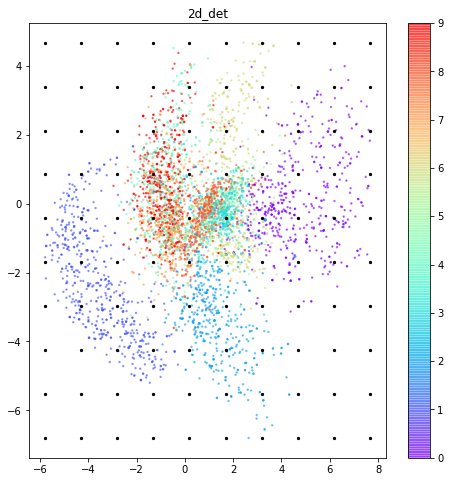

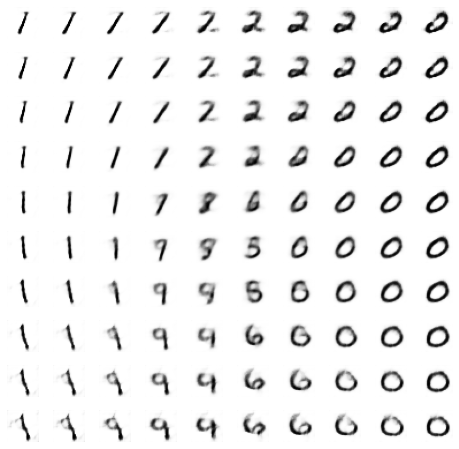

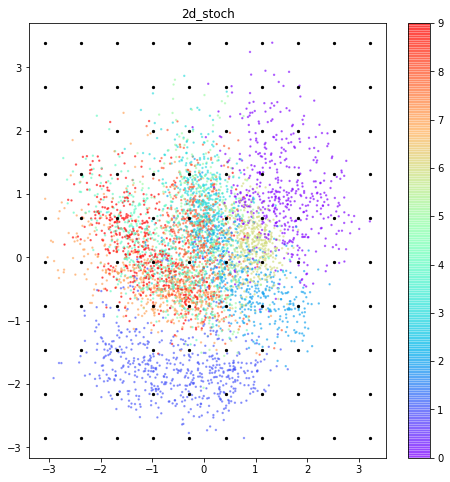

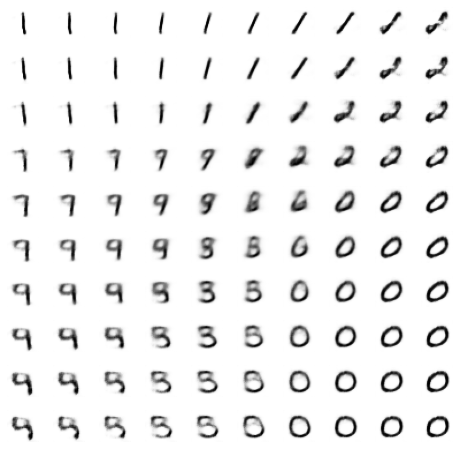

In [119]:
# Generate images from 2d grid

def generate_from_2d_grid(model):
  n_to_show = 5000 #500
  grid_size = 10
  figsize = 8
  np.random.seed(0)

  np.random.seed(42)
  example_idx = np.random.choice(range(len(x_test)), n_to_show)
  example_images = x_test[example_idx]
  example_labels = y_test[example_idx]
  z_points = model.encode(example_images)

  plt.figure(figsize=(figsize, figsize))
  plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
              , alpha=0.5, s=2)
  plt.colorbar()

  x_min = np.min(z_points[:,0]); x_max = np.max(z_points[:,0]);
  y_min = np.min(z_points[:,1]); y_max = np.max(z_points[:,1]);
  x = np.linspace(x_min, x_max, grid_size)
  y = np.linspace(y_min, y_max, grid_size)
  #x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
  #y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
  xv, yv = np.meshgrid(x, y)
  xv = xv.flatten()
  yv = yv.flatten()
  z_grid = np.array(list(zip(xv, yv)))

  reconst = model.decode(z_grid)

  plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
              , alpha=1, s=5)
  plt.title(model.model_name)
  plt.show()

  fig = plt.figure(figsize=(figsize, figsize))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)
  for i in range(grid_size**2):
      ax = fig.add_subplot(grid_size, grid_size, i+1)
      ax.axis('off')
      ax.imshow(reconst[i, :,:,0], cmap = 'Greys')
  plt.show()

generate_from_2d_grid(model_dict['2d_det'])
generate_from_2d_grid(model_dict['2d_stoch'])
